Following sheet has LSTM Model, **GPU based runtime is preffered** to minimize training period

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/cf/1c/83b87c760144281f0dc4df43578587b59fe3c38f9d660b575adb9480a11a/pmdarima-2.0.4-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=0.11 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/35/00/78ffea3a0ab176267a25ff049518b2582db7ac265bbf27944243d1a81ce2/Cython-3.0.11-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for numpy>=1.21.2 from https://files.pythonhosted.org/packages/17/c1/c31d3637f2641e25c7a19adf2ae822fdaf4ddd198b05d79a92a9ce7cb63e/numpy-2.2.1-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#loading dataset

file_id = "1cXGNQ3NtUERYHbP5Jm4fmZR1jmd2M9ME"
url = f"https://drive.google.com/uc?id={file_id}"

df=pd.read_csv(url,sep=',',parse_dates=True,index_col='DATE')

In [ ]:
df

,VALUE
DATE,
1995-01-03,381.40
1995-01-04,378.25
1995-01-05,375.00
1995-01-06,375.90
1995-01-09,372.45
...,...
2016-11-04,1301.70
2016-11-07,1286.80
2016-11-08,1284.00


<Axes: title={'center': 'Dataset'}, xlabel='DATE'>

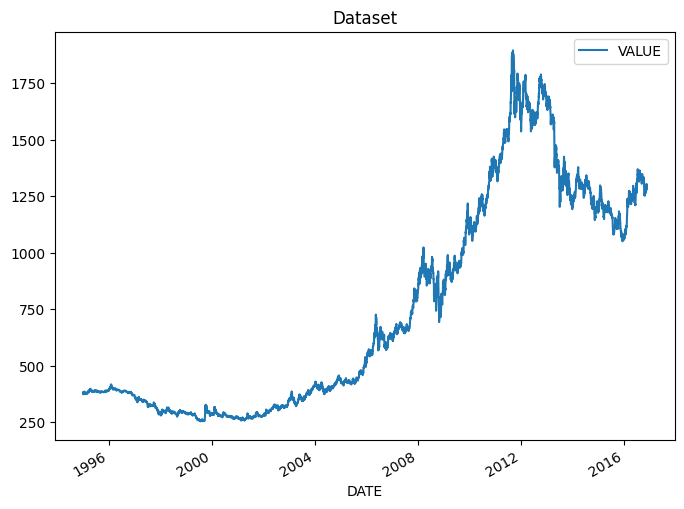

In [ ]:
#visualising dataset
df.plot(figsize=(8,6),title='Dataset')

In [ ]:
#description of dataset
df.describe()

,VALUE
count,5526.000000
mean,745.163409
std,472.874736
min,252.900000
25%,329.737500
50%,499.850000
75%,1197.650000
max,1896.500000


In [ ]:
#Preprocessing - Setting frequency

df.rename(str.lower,axis='columns',inplace=True)   #renaming columns to small letters
df=df.asfreq('B') #setting business days as frequency, this created significant null rows as original dataset only contains working business days (excluding holidays)
df.fillna(method='ffill',inplace=True) #null values are filled with previous day values as null values created are on holidays for which there is no change in stock prices


In [ ]:
#checking for any null values post preprocessing - no null values observed
df.value[df.value.isna()]

,value
DATE,


<Axes: ylabel='value'>

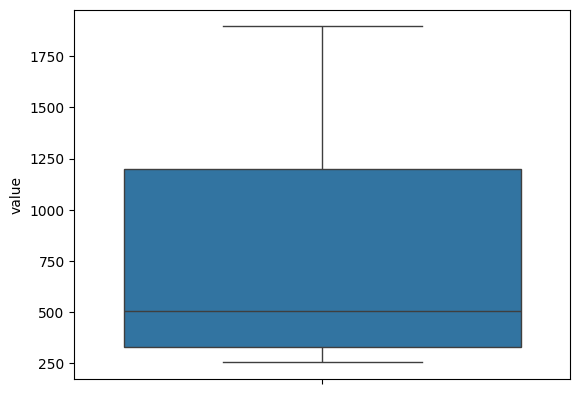

In [ ]:
#boxplot - looking for any potential outliers - none observed
sns.boxplot(df.value)

In [ ]:
#Test Train Split

print(len(df)*.9) #=5132.7
# First 90% data is set as training data and rest for test data
train=df.iloc[:5200]
test=df.iloc[5200:]

5132.7


In [ ]:
test.rename({'value': 'test_data'},axis=1,inplace=True)
train.rename({'value': 'train_data'},axis=1,inplace=True)

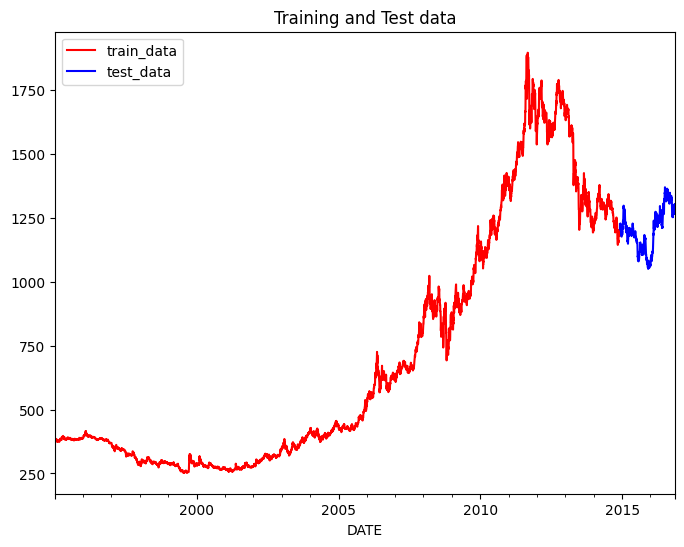

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
train.plot(c='r',ax=ax,title='Training and Test data');
test.plot(c='b',ax=ax);

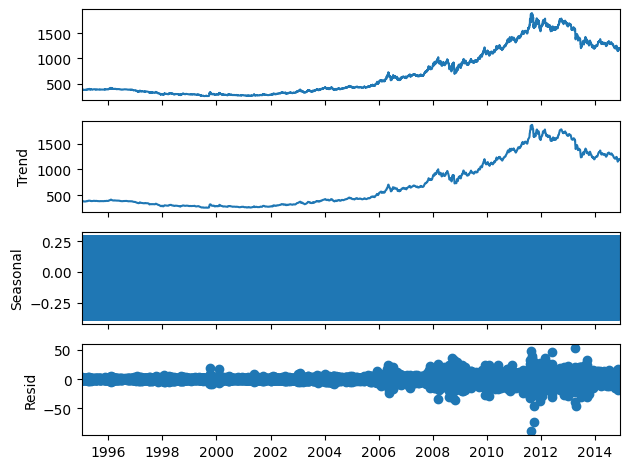

In [ ]:
#Using seasonal decompose to check for any trend and/or seaosonality

result=seasonal_decompose(train,model='add')
result.plot(); #plotting the trend and seasonality components - observed no significant seasonality

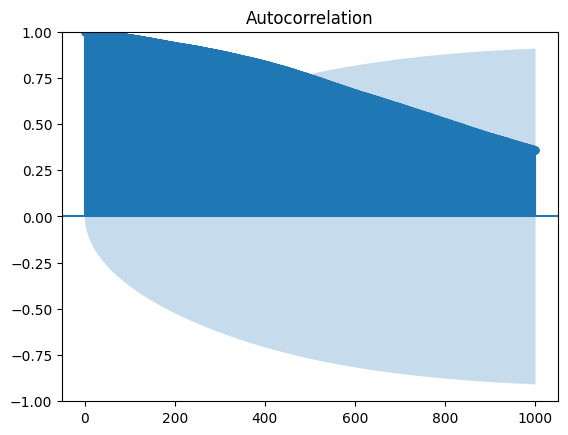

In [ ]:
#plotting acf - there exists a relationship between consequtive timesteps - unfit for MA model
plot_acf(train,lags=1000);


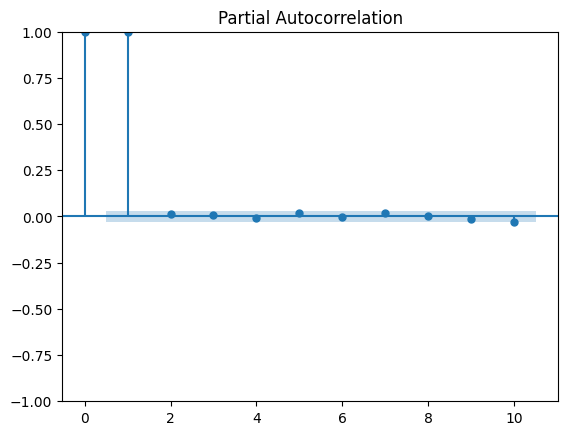

In [ ]:
#plotting pacf - there exists a direct relationship at lag 1
plot_pacf(train,lags=10);

In [ ]:
#Augumented Dickey-Fuller Test to check stationarity - original data - found to be non stationary from p value ( 0.9119329692831357)

adfuller(train)[1]

0.9119329692831348

In [ ]:
#Augumented Dickey-Fuller Test to check stationarity - first order differenced data - stationary --(p<<0.05)

adfuller(train.diff(1)[1:])[1]

3.6440664957277484e-26

In [ ]:
#Using holt winter's double exponential smoothing to fit the dataset

dbl_exp_smooth=ExponentialSmoothing(train,trend='add').fit()

In [ ]:
#predicting using double exponential

predicted_dbl_exp_smooth=pd.DataFrame(dbl_exp_smooth.forecast(503),index=pd.date_range('2014-12-09',freq='B',periods=503),columns=['predicted_value_holt_winters'])

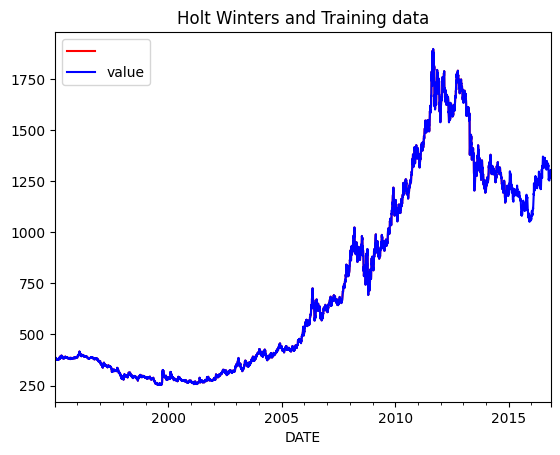

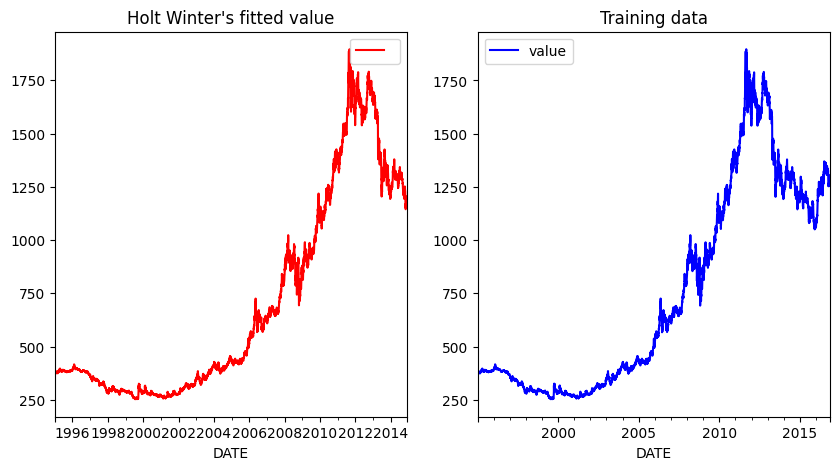

In [ ]:
#Fitting double exponential and plotting - fit works well,graphs are indistinguishable

dbl_exp_smooth.fittedvalues.shift(-1).plot(c='r',legend=True,title='Holt Winters and Training data');
df.value.plot(c='b',legend=True);
fig,ax=plt.subplots(1,2,figsize=(10,5))

dbl_exp_smooth.fittedvalues.shift(-1).plot(c='r',legend=True,ax=ax[0],title="Holt Winter's fitted value");
df.value.plot(c='b',legend=True,ax=ax[1],title="Training data");

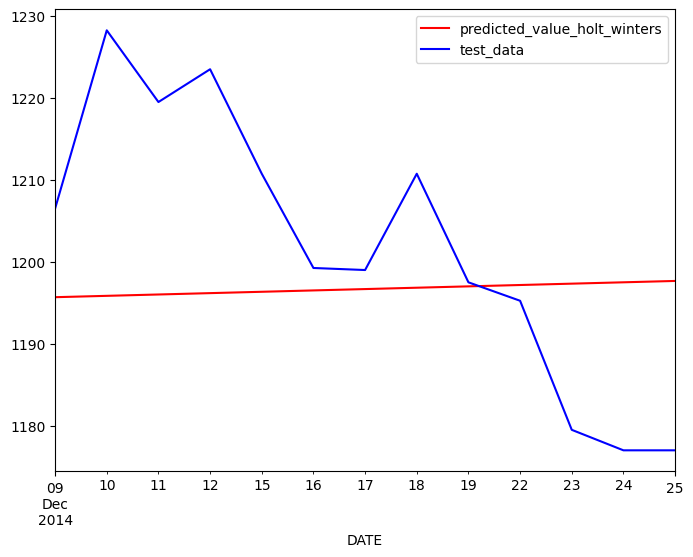

In [ ]:
#plotting first 15 predictions from exponential smoothing

fig,ax=plt.subplots(figsize=(8,6))
predicted_dbl_exp_smooth['2014-12-09':'2014-12-25'].plot(c='r',ax=ax);
test['2014-12-09':'2014-12-25'].plot(c='b',ax=ax);

In [ ]:
#root mean squared error for first 15 predictions
rmse_15=root_mean_squared_error(predicted_dbl_exp_smooth['2014-12-09':'2014-12-25'],test['2014-12-09':'2014-12-25'])
print(rmse_15)

17.645925519111465


<Axes: xlabel='DATE'>

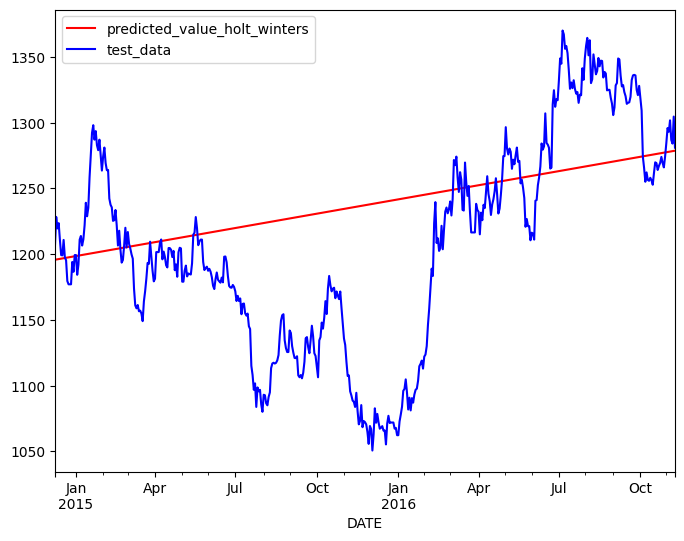

In [ ]:
#plotting entire predictions from exponential smoothing

fig,ax=plt.subplots(figsize=(8,6))
predicted_dbl_exp_smooth.plot(c='r',ax=ax)
test.plot(c='b',ax=ax)

In [ ]:
#root mean squared error for entire predictions
rmse=root_mean_squared_error(predicted_dbl_exp_smooth,test)
print(rmse)

78.32137143271997


In [ ]:
#Using auto-arima to check for optimal MA,Differencing,AR order

stepwise_fit=auto_arima(train,start_p=1,start_q=1,max_p=5,max_q=5,seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38848.774, Time=7.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38851.484, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38848.178, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38847.974, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38850.721, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=38848.290, Time=1.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38847.300, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=38848.171, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=38847.666, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=38847.498, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=3.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 21.336 seconds


In [ ]:
#Using best model from auto-arima to fit ARIMA Model

arima=ARIMA(train,order=(0,1,1))
arima=arima.fit()

In [ ]:
#Model coefficients

arima.params

,0
ma.L1,-0.032873
sigma2,102.865673


<Axes: xlabel='DATE'>

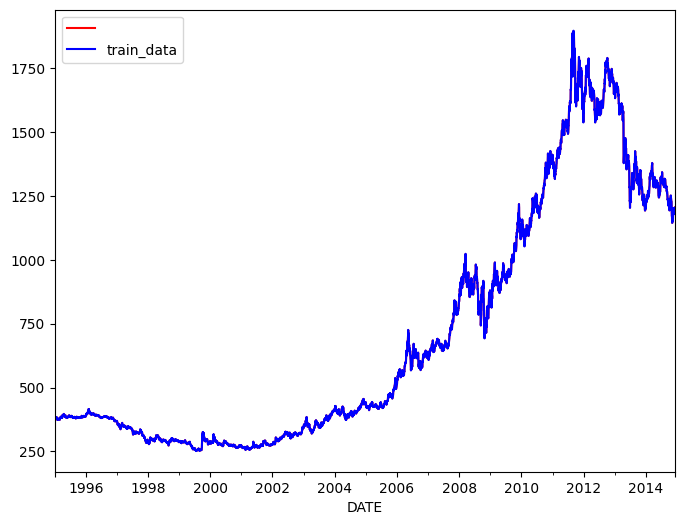

In [ ]:
#Fitting the arima model output for training data - Similar to holt winter's plots are indistinguishable
fig,ax=plt.subplots(figsize=(8,6))
arima.fittedvalues.shift(-1).plot(c='r',legend=True,ax=ax)
train.plot(c='b',legend=True,ax=ax)

In [ ]:
#making predictions based on ARIMA model order ()
predicted_arima=pd.DataFrame(arima.predict('2014-12-09','2016-11-10'))
predicted_arima.rename({'predicted_mean':'predicted_mean_arima'},axis=1,inplace=True)

<Axes: xlabel='DATE'>

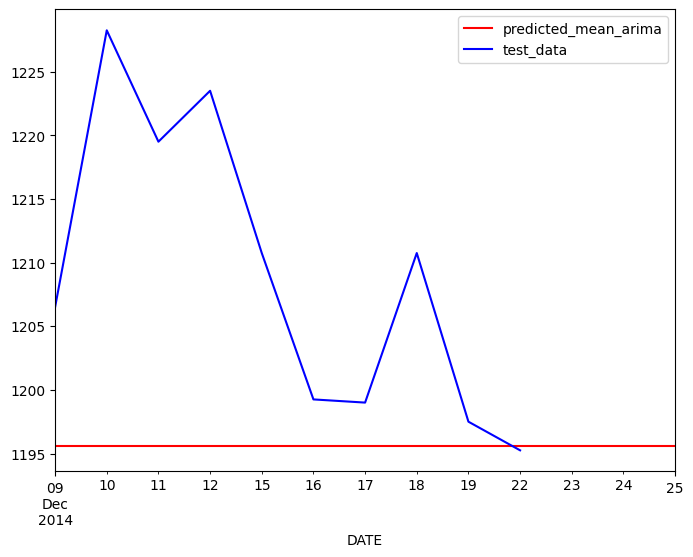

In [ ]:
#Plotting first 10 predictions from ARIMA Model (0,1,1)
fig,ax=plt.subplots(figsize=(8,6))
predicted_arima['2014-12-09':'2014-12-25'].plot(ax=ax,c='r');
test['2014-12-09':'2014-12-22'].plot(ax=ax,c='b')

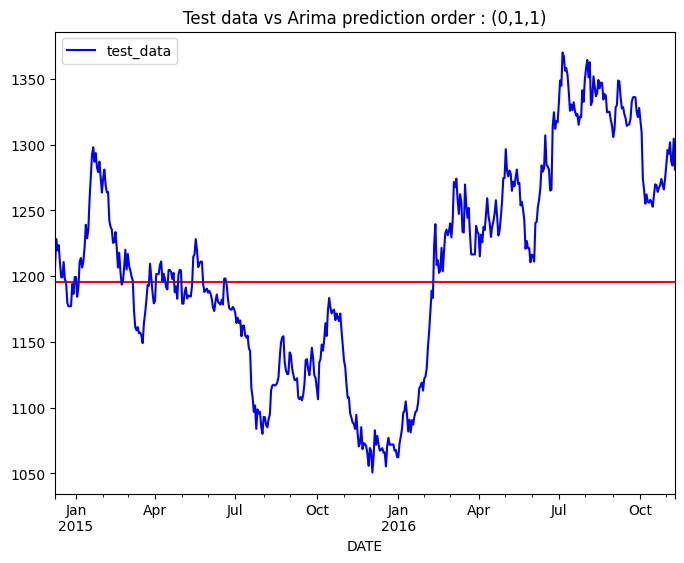

In [ ]:
#Plotting first entire predictions from ARIMA Model
fig,ax=plt.subplots(figsize=(8,6))
arima.predict('2014-12-09','2016-11-10',).plot(ax=ax,c='r',title='Test data vs Arima prediction order : (0,1,1)');
test.plot(ax=ax,c='b',legend='Test');

In [ ]:
#root mean squared error for ARIMA entire predictions
rmse_arima=root_mean_squared_error(arima.predict('2014-12-09','2016-11-10',),test)
print(rmse_arima)

80.88492127407835


In [ ]:
#Using SARIMAX model to fit again ARIMA model expecting any difference in predicitons
#Using different model order as obtained from ACF, PACF and ADFuller test (1,1,0)
sarimax_model=SARIMAX(train,order=(1,1,0),seasonal_order=(0,0,0,0),enforce_stationarity=False)
sarimax_model=sarimax_model.fit()

In [ ]:
#Prediction using sarimax model
predicted_sarima=pd.DataFrame(sarimax_model.predict('2014-12-09','2016-11-10',typ='levels'))
predicted_sarima.rename({'predicted_mean':'predicted_mean_sarima'},axis=1,inplace=True)

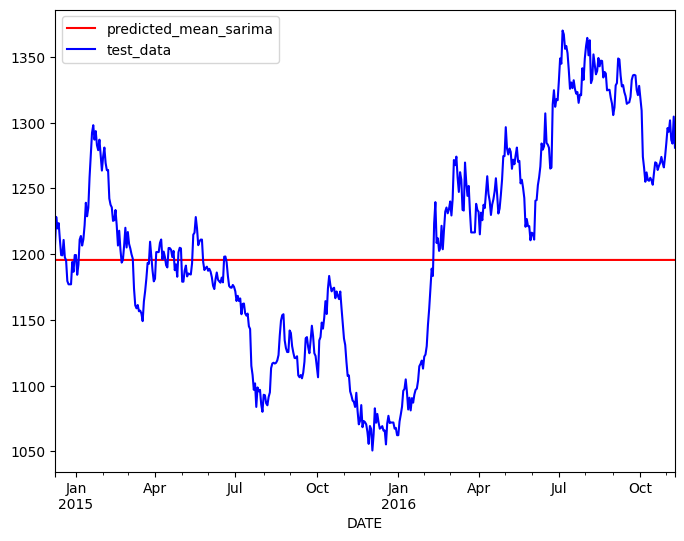

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
predicted_sarima.plot(c='r',ax=ax);
test.plot(c='b',ax=ax);

In [ ]:
#root mean squared error for SARIMA entire predictions
rmse_sarima=root_mean_squared_error(sarimax_model.predict('2014-12-09','2016-11-10',typ='levels'),test)
print(f'RMSE of SARIMA ORDER : 1,1,0 : {rmse_sarima}')

RMSE of SARIMA ORDER : 1,1,0 : 80.88741192243442


In [ ]:
#Preparing dataset for LSTM
#Scaling the data between -1 and 1 using scikit Learn's MinMaxScaler
'''
scaler=MinMaxScaler(feature_range=(0,1)) #(-1,1)
train_scaled=scaler.fit_transform(train.value.values.reshape(-1,1))
test_scaled=scaler.transform(test.value.values.reshape(-1,1))
train_scaled=pd.Series(train_scaled.reshape(1,-1)[0],index=train.index)
test_scaled=pd.Series(test_scaled.reshape(1,-1)[0],index=test.index)

'''

'\nscaler=MinMaxScaler(feature_range=(0,1)) #(-1,1)\ntrain_scaled=scaler.fit_transform(train.value.values.reshape(-1,1))\ntest_scaled=scaler.transform(test.value.values.reshape(-1,1))\ntrain_scaled=pd.Series(train_scaled.reshape(1,-1)[0],index=train.index)\ntest_scaled=pd.Series(test_scaled.reshape(1,-1)[0],index=test.index)\n\n'

In [ ]:
'''
tf.random.set_seed(42)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_scaled,
    targets=train_scaled[seq_length:],
    sequence_length=seq_length,
    batch_size=1,
    shuffle=False,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    test_scaled,
    targets=test_scaled[seq_length:],
    sequence_length=seq_length,
    batch_size=1,
    seed=42
)
'''

'\ntf.random.set_seed(42)\n\ntrain_ds = tf.keras.utils.timeseries_dataset_from_array(\n    train_scaled,\n    targets=train_scaled[seq_length:],\n    sequence_length=seq_length,\n    batch_size=1,\n    shuffle=False,\n    seed=42\n)\nvalid_ds = tf.keras.utils.timeseries_dataset_from_array(\n    test_scaled,\n    targets=test_scaled[seq_length:],\n    sequence_length=seq_length,\n    batch_size=1,\n    seed=42\n)\n'

In [ ]:
#Choosen 120 training step length for NN Model - Arbitrary choice
seq_length = 120

In [ ]:
#Spliting dataset for NN Model
#120 is adjusted in test dataset to enable model to predict from first value of test data (instead of after first 120 steps)

train_data=df.value.values[:5200]
test_data=df.value.values[5200-120:]

In [ ]:
#Preparing dataset for LSTM
#Scaling the data between -1 and 1 using scikit Learn's MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1)) #(-1,1)
x_train=scaler.fit_transform(train_data.reshape(-1,1))
x_test=scaler.transform(test_data.reshape(-1,1))

In [ ]:
#Preparing sequential arrays of length 120 for LSTM.
#Training dataset is split into consequtive sequential timesteps of length

xtrain,ytrain= [],[]

for i in range(120, len(x_train)):
    xtrain.append(x_train[i-120:i,0])
    ytrain.append(x_train[i,0])

x_train, y_train = np.array(xtrain), np.array(ytrain)
x_train = np.reshape(x_train,  (x_train.shape[0], x_train.shape[1], 1))

xtest = []
y_test = df.value.values[5200:]

for i in range(120, len(x_test)):
    xtest.append(x_test[i-120:i])

x_test = np.array(xtest)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#length of training dataset
print(len(x_train),len(y_train))

5080 5080


In [ ]:
#length of test dataset
print(len(x_test),len(y_test))

503 503


In [ ]:
#Building NN model based on LSTM
#Dropout layers are used in between LSTM layers to minimize overfitting
#LSTM Layers are followed by a layer of generic neurons and final layer with a single neuron with no activation function to regress the output

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100,  input_shape=(120, 1),return_sequences=True, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50,return_sequences=True, kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(20,return_sequences=False,  kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
#Early stopping callback is used to prevent running of epochs with no significant reduction in loss

early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True)

In [ ]:
#Model is compiled with Huber as loss functioin and Adam (Adaptive Moment Estimation), a variant of SGD with moment factor to train the model
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["mae"])

*Note : Training with CPU might take considerable amount of time, GPU
based runtime is preferred*

In [ ]:
history = model.fit(x_train,y_train,batch_size=1, epochs=30,callbacks=[early_stopping])

Epoch 1/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 0.0037 - mae: 0.0524
Epoch 2/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 6.2302e-04 - mae: 0.0247
Epoch 3/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 4.0039e-04 - mae: 0.0196
Epoch 4/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 77s 15ms/step - loss: 3.2822e-04 - mae: 0.0172
Epoch 5/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 2.3872e-04 - mae: 0.0153
Epoch 6/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 2.1864e-04 - mae: 0.0145
Epoch 7/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 2.2354e-04 - mae: 0.0145
Epoch 8/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 1.6833e-04 - mae: 0.0129
Epoch 9/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 1.7669e-04 - mae: 0.0126
Epoch 10/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 1.6359e-04 - mae: 0.0124
Epoch 11/30
5080/5080 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 1.3951e-04 - mae: 0.0115
Epoch 12/30
5080/5080 ━

In [ ]:
#prediction on test dataset
predicted_lstm=model.predict(x_test)
predicted_lstm=scaler.inverse_transform(predicted_lstm)
predicted_lstm=pd.Series(predicted_lstm.reshape(1,-1)[0],name='predicted_mean_LSTM' ,index=test.index)
fig,ax=plt.subplots(figsize=(10,8))
predicted_lstm.plot(ax=ax,legend=True)
test.plot(ax=ax)

In [ ]:
#calculating root mean squared error for LSTM predicted output
rmse_lstm=root_mean_squared_error(y_test,predicted_lstm)
print(rmse_lstm)

In [ ]:
#Comparing RMSE of all predictons with Mean and Standard Deviation of test dataset
print(f'Standard deviation of test data : {test.std()}')
print(f'Mean of test data : {test.mean()}')
print(f'RMSE and Mean of Holt Winters : {rmse} and {predicted_dbl_exp_smooth.mean()}')
print(f'RMSE and Mean of ARIMA (0,1,1) : {rmse_arima} and {predicted_arima.mean()}')
print(f'RMSE and Mean of SARIMA (1,1,0): {rmse_sarima} and {predicted_sarima.mean()}')
print(f'RMSE and Mean of LSTM : {rmse_lstm} and {predicted_lstm.mean()}')

In [ ]:
#Plotting Predictions by Various Model

fig,ax=plt.subplots(figsize=(8,8))
predicted_dbl_exp_smooth.plot(c='r',legend=True,ax=ax)
predicted_arima.plot(c='b',legend=True,ax=ax)
#predicted_sarima.plot(c='k',legend=True,ax=ax)
predicted_lstm.plot(c='g',legend=True,ax=ax)
test.plot(c='y',legend=True,ax=ax)